# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [1]:

from dps_lake_model import lake_model, get_antropogenic_release

from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator, 
                           ema_logging, Constant, Scenario)

from ema_workbench.analysis import parcoords
from ema_workbench.util.utilities import load_results, save_results
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

ema_logging.log_to_stderr(ema_logging.INFO)

#instantiate the model
lake_model = Model('lakeproblem', function=lake_model)
lake_model.time_horizon = 100

#specify uncertainties
lake_model.uncertainties = [RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('delta', 0.93, 0.99)]

# set levers, one for each time step
lake_model.levers = [RealParameter('c1', -2, 2),
                    RealParameter('c2', -2, 2),
                    RealParameter('r1', 0, 2),
                    RealParameter('r2', 0, 2),
                    RealParameter('w1', 0, 1)] 

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

lake_model.constantcs = [Constant('alpha', 0.41),
                         Constant('reps', 150)]

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]


C:\Users\na0e2\Miniconda3\lib\site-packages\ema_workbench\analysis\prim.py:31: ImportWarning: altair based interactive inspection not available
  "inspection not available"), ImportWarning)


In [47]:
import functools

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

def maxp(data):
    return np.sum(data<=0.75)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)

robust_metrics = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                               variable_name='max_P', function=maxp),
                  ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                               variable_name='inertia', function=inertia),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                               variable_name='reliability', function=reliability),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                               variable_name='utility', function=utility)]


**2) Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this. What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

In [3]:
from ema_workbench.em_framework import sample_uncertainties, MonteCarloSampler

n_scenarios = 50
scenarios = sample_uncertainties(lake_model, n_scenarios, MonteCarloSampler)


In [4]:
from ema_workbench.em_framework import sample_uncertainties, MonteCarloSampler

with MultiprocessingEvaluator(lake_model) as evaluator:
    robust_results = evaluator.robust_optimize(robust_metrics, scenarios, 
                            nfe=1000, epsilons=[0.05,]*len(robust_metrics), convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 495/1000 nfe
[MainProcess/INFO] generation 10: 986/1000 nfe
[MainProcess/INFO] optimization completed, found 15 solutions
[MainProcess/INFO] terminating pool


In [5]:
robust_results[0]

,c1,c2,r1,r2,w1,max_P,inertia,reliability,utility
0,-1.946775,-0.543034,0.339423,0.987878,0.631653,0.04,1.0,0.04,0.72
1,1.579781,0.507524,1.382751,0.036934,0.105415,0.14,1.0,0.14,0.70
2,1.472154,0.851129,1.409060,1.678657,0.283591,0.06,1.0,0.06,0.66
3,0.613586,0.181813,0.252994,1.849343,0.447298,0.44,1.0,0.44,0.60
4,0.310974,0.966486,0.292125,1.532831,0.177426,0.36,1.0,0.36,0.58
5,0.503878,0.181813,0.311679,1.849343,0.924570,0.56,1.0,0.56,0.46
6,0.561132,0.181813,0.252994,0.753740,0.447298,0.24,1.0,0.24,0.68
7,0.383720,0.966486,0.300409,1.532831,0.988727,0.66,1.0,0.66,0.38
8,0.561132,0.181813,0.276932,0.755011,0.447298,0.28,1.0,0.28,0.66
9,0.561132,0.227978,0.236133,0.748835,0.394362,0.32,1.0,0.32,0.64


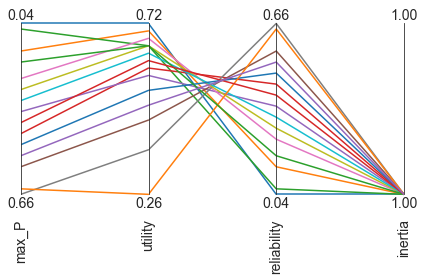

In [6]:
outcomes = robust_results[0].loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)


axes.invert_axis('max_P')

## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


In [51]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE,
                                     expected_range=(0,5)),
                       ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,2)),
                       ScalarOutcome('inertia', kind=ScalarOutcome.MAXIMIZE,
                                    expected_range=(0,1)),
                       ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE,
                                     expected_range=(0,1))]

convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

In [52]:
with MultiprocessingEvaluator(lake_model) as evaluator:
    results, convergence = evaluator.robust_optimize(robust_metrics, scenarios = 50, nfe = 1000, epsilons=[0.05, 0.05, 0.05, 0.05], searchover='levers',
                                convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] generation 5: 494/1000 nfe
[MainProcess/INFO] generation 10: 989/1000 nfe
[MainProcess/INFO] optimization completed, found 16 solutions
[MainProcess/INFO] terminating pool


**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

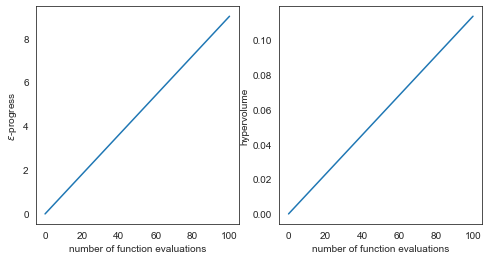

In [53]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

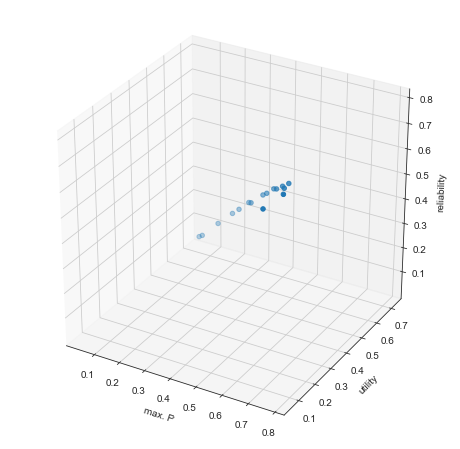

In [54]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D  

outcomes = results.loc[:, ['max_P', 'utility', 'reliability', 'inertia']]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outcomes.max_P, outcomes.utility, outcomes.reliability)
ax.set_xlabel('max. P')
ax.set_ylabel('utility')
ax.set_zlabel('reliability')
plt.show()

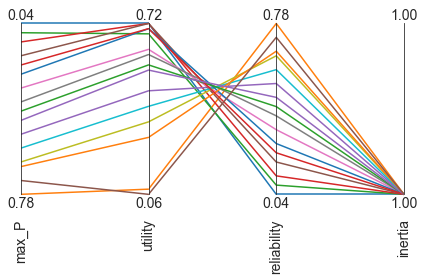

In [55]:
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)


axes.invert_axis('max_P') 
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

In [56]:
results.to_csv('assignment10_results.csv', index = False)

In [57]:
from ema_workbench import Policy

new_results = pd.read_csv("assignment10_results.csv", index_col=0)
new_results.iloc[:, 0:4].T.to_dict()

policy = []

for i in range(len(new_results)):
    pol = Policy(name="Policy " + str(i), 
                        c1 = new_results.iloc[i,0] , 
                        c2 = new_results.iloc[i,1], 
                        r1 = new_results.iloc[i,2], 
                        r2 = new_results.iloc[i,3], 
                        w1 = new_results.iloc[i,4])
    policy.append(pol)

policy

C:\Users\na0e2\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  after removing the cwd from sys.path.


[Policy({'c1': -1.1881940450404826, 'c2': 1.4598295911350951, 'r1': 1.4582735489493703, 'r2': 0.17578516114506915, 'w1': 0.04}),
 Policy({'c1': 0.20386359265149026, 'c2': 0.6005753849609707, 'r1': 1.2932396649917668, 'r2': 0.8977465243849809, 'w1': 0.78}),
 Policy({'c1': -0.07687245393478781, 'c2': 1.0187641407326395, 'r1': 0.8240552502831913, 'r2': 0.7505993281542859, 'w1': 0.08}),
 Policy({'c1': -0.5631502533581454, 'c2': 1.2091570632544788, 'r1': 1.4766760634188494, 'r2': 0.7597018350141328, 'w1': 0.12}),
 Policy({'c1': 0.3074292886118956, 'c2': 1.0187641407326395, 'r1': 0.5782953257960947, 'r2': 0.7505993281542859, 'w1': 0.52}),
 Policy({'c1': -0.8557332698339439, 'c2': 1.0298614660530268, 'r1': 1.9785844275138265, 'r2': 0.7537833970882951, 'w1': 0.18}),
 Policy({'c1': -0.03695004421464332, 'c2': 0.21944063678677966, 'r1': 1.2860547108381926, 'r2': 0.9908820919520144, 'w1': 0.32}),
 Policy({'c1': -1.3529984004453703, 'c2': 0.5090644305334164, 'r1': 1.3818272728079002, 'r2': 0.98815

In [58]:
n_scenarios = 1000

with MultiprocessingEvaluator(lake_model) as evaluator:
    results_1000, outcomes_1000 = evaluator.perform_experiments(n_scenarios, policy)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 16 policies * 1 model(s) = 16000 experiments
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 6400 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9600 cases completed
[MainProcess/INFO] 11200 cases completed
[MainProcess/INFO] 12800 cases completed
[MainProcess/INFO] 14400 cases completed
[MainProcess/INFO] 16000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [59]:
results_1000

,b,delta,mean,q,stdev,c1,c2,r1,r2,w1,scenario,policy,model
0,0.172127,0.982024,0.043785,2.387650,0.001433,-1.188194,1.459830,1.458274,0.175785,0.04,5650,Policy 0,lakeproblem
1,0.223946,0.982687,0.015493,3.481230,0.001421,-1.188194,1.459830,1.458274,0.175785,0.04,5651,Policy 0,lakeproblem
2,0.331634,0.970149,0.022235,2.308382,0.004313,-1.188194,1.459830,1.458274,0.175785,0.04,5652,Policy 0,lakeproblem
3,0.188523,0.984351,0.015854,3.207033,0.001621,-1.188194,1.459830,1.458274,0.175785,0.04,5653,Policy 0,lakeproblem
4,0.282626,0.953051,0.022603,3.514259,0.002956,-1.188194,1.459830,1.458274,0.175785,0.04,5654,Policy 0,lakeproblem
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15995,0.349724,0.963245,0.045355,3.892398,0.001889,0.203864,0.707493,1.131210,0.897747,0.72,6645,Policy 15,lakeproblem
15996,0.406224,0.984988,0.016079,3.364391,0.003132,0.203864,0.707493,1.131210,0.897747,0.72,6646,Policy 15,lakeproblem
15997,0.345806,0.970752,0.047967,2.673983,0.001559,0.203864,0.707493,1.131210,0.897747,0.72,6647,Policy 15,lakeproblem
15998,0.264943,0.952014,0.013099,2.433356,0.002204,0.203864,0.707493,1.131210,0.897747,0.72,6648,Policy 15,lakeproblem


In [60]:
robustness_reeval = pd.DataFrame(columns = ["policy", "max_P", "utility", "inertia", "reliability"])
maxp_fun = functools.partial(robustness, SMALLER, 0.75)
inertia_fun = functools.partial(robustness, LARGER, 0.6)
reliability_fun = functools.partial(robustness, LARGER, 0.99)
utility_fun = functools.partial(robustness, LARGER, 0.75)

for p in results_1000["policy"].unique():

    index = results_1000[results_1000["policy"] == p].index
    
    maxp_fun = maxp(outcomes_1000["max_P"][index])
    utility = utility_fun(outcomes_1000["utility"][index])
    inertia = inertia_fun(outcomes_1000["inertia"][index])
    reliability = reliability_fun(outcomes_1000["reliability"][index])
    
        
    policy_line = [p, max_P, utility, inertia, reliability]
    
    robustness_reeval = robustness_reeval.append(pd.Series(policy_line, index=["policy", "max_P", "utility", "inertia", "reliability"]), ignore_index=True) 

    
robustness_reeval

,policy,max_P,utility,inertia,reliability
0,Policy 0,0.091,0.719,1.0,0.099
1,Policy 1,0.091,0.120,1.0,0.657
2,Policy 2,0.091,0.719,1.0,0.100
3,Policy 3,0.091,0.719,1.0,0.099
4,Policy 4,0.091,0.719,1.0,0.100
5,Policy 5,0.091,0.719,1.0,0.101
6,Policy 6,0.091,0.096,1.0,0.665
7,Policy 7,0.091,0.719,1.0,0.100
8,Policy 8,0.091,0.719,1.0,0.099
9,Policy 9,0.091,0.688,1.0,0.098


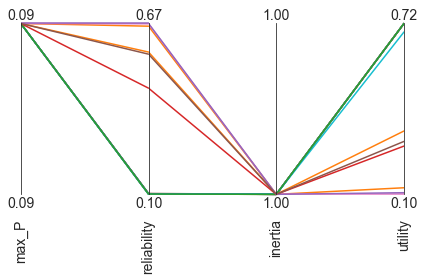

In [62]:
out = robustness_reeval.loc[:,['max_P', 'reliability', 'inertia', 'utility']]

limits = parcoords.get_limits(out)
axes = parcoords.ParallelAxes(limits)
axes.plot(out)


axes.invert_axis('max_P') 
plt.show()

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from ema_workbench.analysis import prim
from ema_workbench import load_results

mordm = pd.read_csv('mordm filtered polices.csv')

In [69]:
mordm.iloc[:, 0:4].T.to_dict()

policy = []

for i in range(len(mordm)):
    pol = Policy(name="Policy " + str(i), 
                        c1 = mordm.iloc[i,0] , 
                        c2 = mordm.iloc[i,1], 
                        r1 = mordm.iloc[i,2], 
                        r2 = mordm.iloc[i,3], 
                        w1 = mordm.iloc[i,4])
    policy.append(pol)

policy

[Policy({'c1': 6, 'c2': 0.2612242192236867, 'r1': 0.6385720108971452, 'r2': 0.059681049376876315, 'w1': 1.335684410114423}),
 Policy({'c1': 7, 'c2': 0.3187758829037494, 'r1': 0.547247600941963, 'r2': 0.3690108464753564, 'w1': 1.6433327702332945}),
 Policy({'c1': 9, 'c2': 0.2585074049590883, 'r1': 0.0722740179738296, 'r2': 0.5715749103698893, 'w1': 1.842959345016548})]

In [71]:
n_scenarios = 1000

with MultiprocessingEvaluator(lake_model) as evaluator:
    mordm_results, mordm_outcomes = evaluator.perform_experiments(n_scenarios, policy)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [72]:
mordm_robustness = pd.DataFrame(columns = ["policy", "max_P", "utility", "inertia", "reliability"])
maxp_fun = functools.partial(robustness, SMALLER, 0.75)
inertia_fun = functools.partial(robustness, LARGER, 0.6)
reliability_fun = functools.partial(robustness, LARGER, 0.99)
utility_fun = functools.partial(robustness, LARGER, 0.75)

for p in mordm_results["policy"].unique():

    index = mordm_results[mordm_results["policy"] == p].index
    
    maxp_fun = maxp(mordm_outcomes["max_P"][index])
    utility = utility_fun(mordm_outcomes["utility"][index])
    inertia = inertia_fun(mordm_outcomes["inertia"][index])
    reliability = reliability_fun(mordm_outcomes["reliability"][index])
    
        
    policy_line = [p, max_P, utility, inertia, reliability]
    
    mordm_robustness = mordm_robustness.append(pd.Series(policy_line, index=["policy", "max_P", "utility", "inertia", "reliability"]), ignore_index=True) 

    
mordm_robustness

,policy,max_P,utility,inertia,reliability
0,Policy 0,0.091,0.102,1.000,0.092
1,Policy 1,0.091,0.315,0.996,0.092
2,Policy 2,0.091,0.686,1.000,0.092


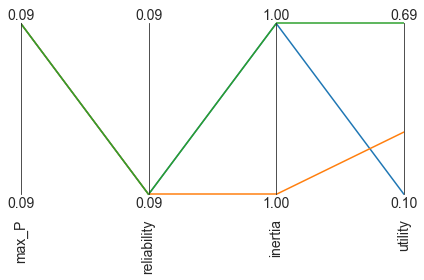

In [73]:
out = mordm_robustness.loc[:,['max_P', 'reliability', 'inertia', 'utility']]

limits = parcoords.get_limits(out)
axes = parcoords.ParallelAxes(limits)
axes.plot(out)


axes.invert_axis('max_P') 
plt.show()